In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import random
import os
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
train_dir = 'C:/Users/fdoktorm/OneDrive - Intel Corporation/Documents/Private/Data Science/Naya College/Final Project Brain Tumor Classification/Brain-Tumor-Classification-DataSet-master/Training/'
test_dir = 'C:/Users/fdoktorm/OneDrive - Intel Corporation/Documents/Private/Data Science/Naya College/Final Project Brain Tumor Classification/Brain-Tumor-Classification-DataSet-master/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
# print(label)
# print(image)
# print(train_paths[0])
# print(train_labels[0])


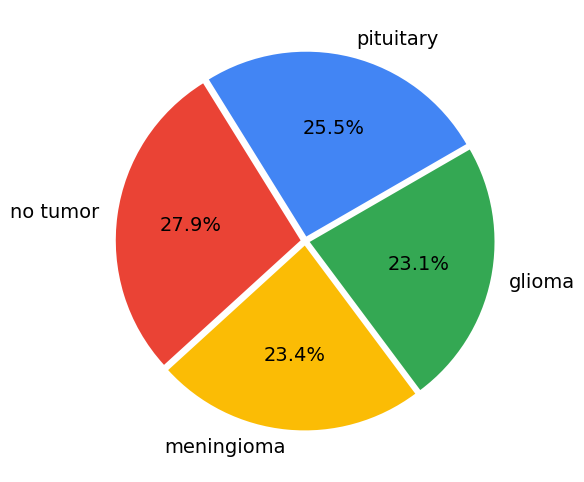

In [3]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','no tumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

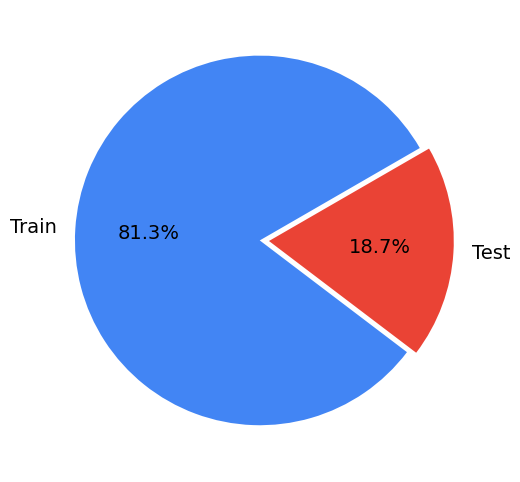

In [5]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2)) #Adjust image brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2)) #Adjust image contrast
    image = np.array(image)/255.0
    return image

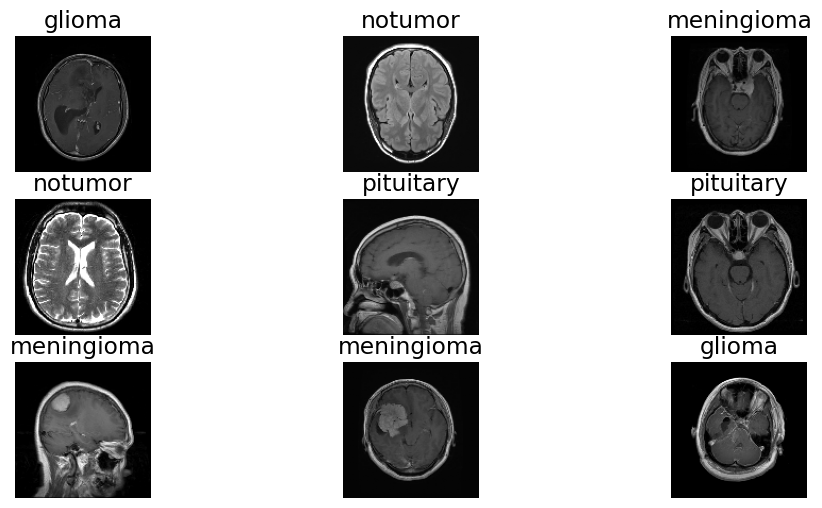

In [7]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:60])
labels = train_labels[50:60]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 10):
    fig.add_subplot(3, 3, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [8]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [9]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [12]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 5
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 [==============================] - 243s 849ms/step - loss: 0.4405 - sparse_categorical_accuracy: 0.8370
Epoch 2/5
285/285 [==============================] - 234s 823ms/step - loss: 0.2405 - sparse_categorical_accuracy: 0.9109
Epoch 3/5
285/285 [==============================] - 236s 826ms/step - loss: 0.1531 - sparse_categorical_accuracy: 0.9420
Epoch 4/5
285/285 [==============================] - 255s 894ms/step - loss: 0.1111 - sparse_categorical_accuracy: 0.9580
Epoch 5/5
285/285 [==============================] - 257s 900ms/step - loss: 0.0723 - sparse_categorical_accuracy: 0.9749


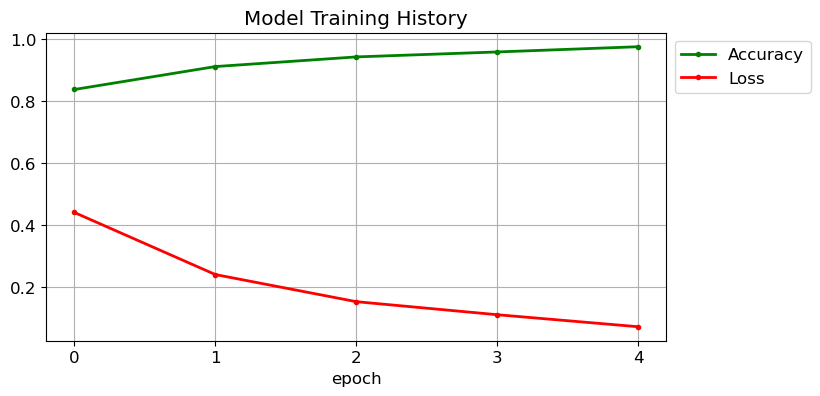

In [13]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

EVALUATING MODEL WITH TEST SAMPLES

In [14]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  2%|██                                                                                 | 1/40 [00:01<00:51,  1.31s/it]

1/1 [==============================] - 1s 993ms/step


  5%|████▏                                                                              | 2/40 [00:02<00:47,  1.25s/it]

1/1 [==============================] - 1s 1s/step


  8%|██████▏                                                                            | 3/40 [00:03<00:46,  1.26s/it]

1/1 [==============================] - 1s 1s/step


 10%|████████▎                                                                          | 4/40 [00:05<00:44,  1.24s/it]

1/1 [==============================] - 1s 1s/step


 12%|██████████▍                                                                        | 5/40 [00:06<00:44,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 15%|████████████▍                                                                      | 6/40 [00:07<00:44,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 18%|██████████████▌                                                                    | 7/40 [00:09<00:44,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 20%|████████████████▌                                                                  | 8/40 [00:10<00:43,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 22%|██████████████████▋                                                                | 9/40 [00:11<00:41,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 25%|████████████████████▌                                                             | 10/40 [00:13<00:40,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 28%|██████████████████████▌                                                           | 11/40 [00:14<00:37,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 30%|████████████████████████▌                                                         | 12/40 [00:15<00:36,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 32%|██████████████████████████▋                                                       | 13/40 [00:16<00:34,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 35%|████████████████████████████▋                                                     | 14/40 [00:18<00:33,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:19<00:32,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:20<00:31,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:22<00:30,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:23<00:30,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:25<00:29,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:26<00:28,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:28<00:27,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:29<00:26,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:31<00:25,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:33<00:25,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:34<00:23,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:36<00:21,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:37<00:19,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:38<00:17,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:40<00:15,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:41<00:13,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:42<00:11,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:43<00:10,  1.30s/it]

1/1 [==============================] - 1s 829ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:44<00:08,  1.22s/it]

1/1 [==============================] - 1s 806ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:45<00:06,  1.16s/it]

1/1 [==============================] - 1s 831ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:46<00:05,  1.13s/it]

1/1 [==============================] - 1s 952ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:48<00:04,  1.14s/it]

1/1 [==============================] - 1s 808ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:49<00:03,  1.11s/it]

1/1 [==============================] - 1s 787ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:50<00:02,  1.08s/it]

1/1 [==============================] - 1s 894ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:51<00:01,  1.09s/it]

1/1 [==============================] - 1s 823ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.07s/it]

1/1 [==============================] - 1s 892ms/step


41it [00:53,  1.30s/it]                                                                                                


In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.92      0.97      0.94       300
  meningioma       0.94      0.92      0.93       306
     notumor       0.99      1.00      0.99       405
   pituitary       1.00      0.95      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [21]:
y_true

['meningioma',
 'notumor',
 'glioma',
 'pituitary',
 'meningioma',
 'glioma',
 'meningioma',
 'notumor',
 'meningioma',
 'notumor',
 'pituitary',
 'meningioma',
 'notumor',
 'glioma',
 'pituitary',
 'notumor',
 'meningioma',
 'glioma',
 'pituitary',
 'meningioma',
 'glioma',
 'meningioma',
 'notumor',
 'meningioma',
 'meningioma',
 'notumor',
 'meningioma',
 'glioma',
 'glioma',
 'pituitary',
 'meningioma',
 'notumor',
 'pituitary',
 'notumor',
 'notumor',
 'glioma',
 'notumor',
 'glioma',
 'glioma',
 'pituitary',
 'glioma',
 'meningioma',
 'glioma',
 'meningioma',
 'pituitary',
 'meningioma',
 'notumor',
 'pituitary',
 'pituitary',
 'glioma',
 'glioma',
 'notumor',
 'notumor',
 'notumor',
 'glioma',
 'meningioma',
 'meningioma',
 'meningioma',
 'notumor',
 'notumor',
 'notumor',
 'notumor',
 'meningioma',
 'pituitary',
 'pituitary',
 'notumor',
 'pituitary',
 'meningioma',
 'notumor',
 'notumor',
 'pituitary',
 'notumor',
 'glioma',
 'notumor',
 'notumor',
 'meningioma',
 'meningioma'

## Confusion Matrix

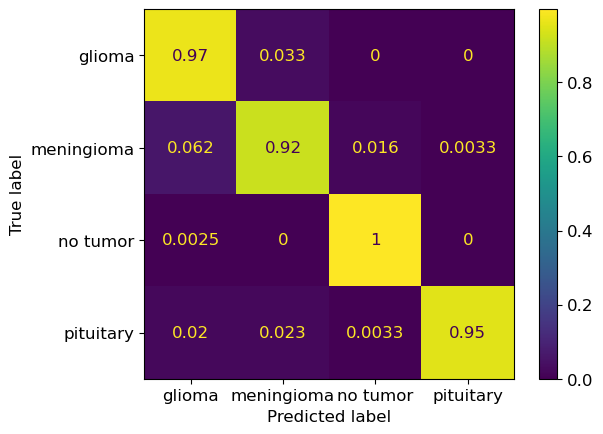

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      normalize = 'true'
                     )

cmd = ConfusionMatrixDisplay(cm, display_labels = ['glioma', 'meningioma', 'no tumor','pituitary'])
cmd.plot()